In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import xarray as xr
import pandas as pd
import os
import datetime


import cartopy
import cartopy.crs as ccrs
from pyresample import load_area, geometry

import quantnn

In [104]:
path_to_rain_gauge_data = '../reference/'
area_path='../dataset/downloads/files/areas.yaml'
area_def = load_area(area_path, 'full_disk')

def get_gauge_locations():
    lonlats = pd.read_pickle(os.path.join(path_to_rain_gauge_data,'rain_gauge_locs.pckl'))
    colrows = []
    for lon, lat in zip(lonlats['lon'], lonlats['lat']):
        col, row = area_def.lonlat2colrow(lon, lat)
        colrows.append((col, row))

    colrows = pd.DataFrame(colrows, columns = ['cols', 'rows'])

    return(colrows)


In [128]:
gauge_locs = get_gauge_locations()

In [145]:
def preprocess_colrow(ds, col, row):
    dsnew = ds.copy()
    region_corners_idx_low, __, __, region_corners_idy_low = dsnew.ind_extent
    dsnew = dsnew[dict(y=row-region_corners_idy_low,x=col-region_corners_idx_low)]
    t = datetime.datetime.strptime(dsnew.attrs['end'], '%Y-%m-%d %H:%M:%S')
    dsnew = dsnew.assign_coords(time=t)
    dsnew = dsnew.expand_dims('time').set_coords('time')
    dsnew.attrs['start'] = ''
    dsnew.attrs['end'] = ''
    dsnew.attrs['datetimes'] = ''
    return(dsnew)

In [152]:
filepath = '../reference/rain_gauge_preds/'
for i in range(len(gauge_locs))[:3]:
    c = gauge_locs.cols[i]
    r = gauge_locs.rows[i]
    combined = xr.open_mfdataset(filepath+'2*.nc', combine='by_coords',
                        concat_dim='time', preprocess=lambda ds: preprocess_colrow(ds, c, r))
    combined.to_netcdf(os.path.join(filepath,'pred_c'+str(c)+'r'+str(r)+'.nc'))

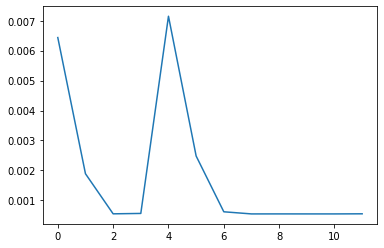

In [153]:
plt.plot(combined.xception_posterior_mean.values)